# RINALMo

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set current dir to the rinalmo path
project_path = 'DNALM_dependencies'
os.chdir(os.path.join(project_path, 'RiNALMo'))

In [2]:
import torch
from rinalmo.pretrained import get_pretrained_model

device = "cuda:0"


In [3]:

model, alphabet = get_pretrained_model(model_name="giga-v1")
model = model.to(device=device)
model.eval()
#seqs = ["ACUUUGGCCA", "CCCGGU", "ACGU"]

#tokens = torch.tensor(alphabet.batch_tokenize(seqs), dtype=torch.int64, device=device)

RiNALMo(
  (embedding): Embedding(22, 1280, padding_idx=1)
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): TransformerBlock(
        (mh_attn): FlashMultiHeadSelfAttention(
          (rotary_emb): RotaryEmbedding()
          (flash_self_attn): FlashAttention()
          (Wqkv): Linear(in_features=1280, out_features=3840, bias=False)
          (attention_dropout): Dropout(p=0.1, inplace=False)
          (out_proj): Linear(in_features=1280, out_features=1280, bias=False)
        )
        (attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (transition): Sequential(
          (0): SwiGLU(
            (linear): Linear(in_features=1280, out_features=3413, bias=True)
            (linear_gate): Linear(in_features=1280, out_features=3413, bias=True)
          )
          (1): Dropout(p=0.0, inplace=False)
          (2): Linear(in_features=3413, out_features=1280, bias=True)
        )
        (out_layer_norm): LayerNorm((1280,), eps=1e-05, elemen

In [4]:
nuc_table = {"A" : 0, "C":1, "G":2, "U":3} # For RINALMo we have Us instead of Ts

def mutate_sequence(seq):
    seq = seq.upper()
    mutated_sequences = {'seq':[], 'mutation_pos':[], 'nuc':[], 'var_nt_idx':[]} #,'gene_id': []}
    #mutated_sequences['gene_id'].append(gene_id)
    mutated_sequences['seq'].append(seq)
    mutated_sequences['mutation_pos'].append(-1)
    mutated_sequences['nuc'].append('real sequence')
    mutated_sequences['var_nt_idx'].append(-1)


    mutate_until_position = len(seq)

    for i in range(mutate_until_position):
        for nuc in ['A', 'C', 'G', 'U']:
            if nuc != seq[i]:
                #mutated_sequences['gene_id'].append(gene_id)
                mutated_sequences['seq'].append(seq[:i] + nuc + seq[i+1:])
                mutated_sequences['mutation_pos'].append(i)
                mutated_sequences['nuc'].append(nuc)
                mutated_sequences['var_nt_idx'].append(nuc_table[nuc])

    mutations_df = pd.DataFrame(mutated_sequences)

    return mutations_df

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class RNADataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

def custom_collate_fn(batch):

    # batch is a list of sequences
    tokenized_batch = torch.tensor(alphabet.batch_tokenize(batch), 
                                   dtype=torch.int64, 
                                   device=device)
    return tokenized_batch

batch_size = 64

def create_dataloader(dataset, batch_size=batch_size):
    rna_dataset = RNADataset(list(dataset['seq'].values))
    data_loader = DataLoader(rna_dataset, 
                            batch_size=batch_size, 
                            shuffle=False,
                            collate_fn=custom_collate_fn)
    return data_loader

In [6]:
acgu_idxs = [5, 6, 7, 8]
def model_inference(model, data_loader):

    print(f'Inferencing {len(data_loader)} batches')
    output_arrays = []
    for i, batch_tokens in enumerate(data_loader):
        # get some tokenized sequences (B, L_in)
        
        with torch.no_grad(), torch.cuda.amp.autocast():
            outputs = model(batch_tokens)['logits'].cpu().to(torch.float32)
        output_probs = torch.nn.functional.softmax(outputs, dim=-1)[:,:,acgu_idxs] # B, L_seq, 4
        output_arrays.append(output_probs) 

    print(f'Inferencing done')

    # rebuild to nseqs, L_seq, 4
    snp_reconstruct = torch.concat(output_arrays, axis=0)

    return snp_reconstruct.to(torch.float32).numpy()

In [7]:
def compute_ci_matrix(gene_seq,  get_logit=True, effect_on_ref_only = False):

    dataset = mutate_sequence(gene_seq) 
    data_loader = create_dataloader(dataset)
    snp_reconstruct = model_inference(model, data_loader)
    snp_reconstruct = snp_reconstruct[:,1:-1,:] # discard the beginning of sentence token and end of sentence token
    print(snp_reconstruct.shape)

    non_zero_log_value = 1e-10 #due to the conversion to bfloat16, we need to add a small value to avoid log(0)

    if get_logit: # for the logit add the small value and renormalize such that every prob in one position sums to 1
        snp_reconstruct = snp_reconstruct + non_zero_log_value
        snp_reconstruct = snp_reconstruct/snp_reconstruct.sum(axis=-1)[:,:, np.newaxis]

    seq_len = snp_reconstruct.shape[1]
    snp_effect = np.zeros((seq_len, seq_len,4, 4))
    reference_probs = snp_reconstruct[dataset[dataset['nuc'] == 'real sequence'].index[0]]

    print('shape of the reference probs:', reference_probs.shape)

    if get_logit:
        snp_effect[dataset.iloc[1:]['mutation_pos'].values, : ,  dataset.iloc[1:]['var_nt_idx'].values,:] = np.log2(snp_reconstruct[1:]) - np.log2(1 - snp_reconstruct[1:]) \
            - np.log2(reference_probs) + np.log2(1-reference_probs)
    else:
        snp_effect[dataset.iloc[1:]['mutation_pos'].values, : ,  dataset.iloc[1:]['var_nt_idx'].values,:] = np.log2(snp_reconstruct[1:]+non_zero_log_value) - np.log2(reference_probs+non_zero_log_value)

    if effect_on_ref_only:
        gene_seq_int = dataset.iloc[1:].groupby('mutation_pos').apply(lambda pos_df: (set(range(4)) - set(pos_df['var_nt_idx'])).pop()).values
        snp_effect_on_ref = snp_effect[:,np.arange(seq_len),:, gene_seq_int]
        ci_matrix = np.max(np.abs(snp_effect_on_ref), axis=2)

    else:
        ci_matrix = np.max(np.abs(snp_effect), axis=(2,3))

    return ci_matrix

def plot_ci_matrix(ci_matrix, vmax=None, figsize=[10, 10]):#increase figure size
    plt.rcParams['figure.figsize'] = figsize
    plt.imshow(ci_matrix, cmap="coolwarm", vmax=vmax) if vmax is not None else plt.imshow(ci_matrix, cmap="coolwarm")
    plt.grid(False)
    return plt

## Benchmarking datasets

In [8]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, top_k_accuracy_score, roc_curve
from pathlib import Path

In [9]:
def bpseq2mat(bpseq):
    ci_matrix = np.zeros((len(bpseq),len(bpseq)))
    ci_matrix[np.arange(len(bpseq))[bpseq>0],
              bpseq[bpseq>0]-1] = 1
    return ci_matrix

def open_ct(ct_file):
    seq = ""
    bpseq = []
    with open(ct_file) as f:
        next(f)
        for line in f:
            splitted = line.rstrip().split("\t")
            seq += splitted[1]
            bpseq.append(splitted[4])
    bpseq = np.array(bpseq, dtype=int)
    return seq, bpseq

#create a mask that masks the diagonal and the adjacent diagonals
#the minimum loop length for a RNA secondary structure is 4 https://doi.org/10.1093/nar/16.24.11725 
# that means that secondary structure interactions should be distanced at least by 4 nucelotides
#that equates to a diagonal area centered on the main diagonal of thickness 4 on each side
def create_diag_mask(mask_width = 9, matrix_size = 5): 

    mask = np.zeros((matrix_size, matrix_size))

    for k in range(-mask_width // 2 + 1, mask_width // 2 + 1):
        mask += np.diag(np.ones(matrix_size - abs(k)), k=k)

    mask = 1 - mask
    return mask

def get_triangular_values(matrix):
    
    triang_mask = np.tri(matrix.shape[0],k=-1, dtype=bool)
    
    triangular_flattened = matrix[triang_mask]
    
    return triangular_flattened

def process_ci_matrix(matrix, mask_diag=1, get_max_ij_ji=True):

    if get_max_ij_ji:
        matrix = np.maximum(matrix, matrix.T)
    if mask_diag is not None:
        matrix = matrix * create_diag_mask(mask_width = mask_diag, matrix_size = matrix.shape[0])

    return matrix

def keepmaxperpos(non_diag_ci_matrix):
    #get the max values per row and mask the other values to 0
    max_values = np.max(non_diag_ci_matrix, axis=1, keepdims=True)
    mask = non_diag_ci_matrix == max_values
    non_diag_ci_matrix = non_diag_ci_matrix * mask
    return non_diag_ci_matrix

import itertools
def find_best_pairs(matrix):
    # get list of all pairs, sorted by interaction strength
    pairs = list(itertools.combinations(range(matrix.shape[0]), 2))
    pairs = sorted(pairs, key = lambda x: matrix[x[0],x[1]], reverse=True)
    mask = np.zeros((matrix.shape[0],matrix.shape[0]))
    while len(pairs) > 0:
        # take maxmially scored pair
        max_pair = pairs[0]
        mask[max_pair[0],max_pair[1]] = 1
        # remove all pairs having one of these elements
        pairs = [x for x in pairs if (x[0] not in max_pair) and (x[1] not in max_pair)]
    # multiply with mask
    matrix = matrix * mask
    # resymmetrize
    matrix = np.maximum(matrix, matrix.T)
    return matrix

def plot_ncrna_structure(structure):
    pathlist = Path(os.path.join(data_path, "archiveII/")).rglob('*.ct')
    path = [s for s in pathlist if structure in str(s)][0]
    splitted = str(path).split("/")
    name = splitted[-1]
    basename = "_".join(name.split("_")[:-2])
    probpath = os.path.join("/",*splitted[:-1],"probs",basename+"_probs.npy")
    seq, bpseq = open_ct(path)
    # Predict ci matrix
    ci_matrix = process_ci_matrix(ci_matrix, compute_ci_matrix(seq, effect_on_ref_only=False), get_max_ij_ji=True, mask_diag=1)
    ci_matrix_values = get_triangular_values(find_best_pairs(ci_matrix))
    # Get true matrix
    truematrix = get_triangular_values(bpseq2mat(bpseq))
    # Get fine-tuned predictions
    probs = process_ci_matrix(np.load(probpath), get_max_ij_ji=True, mask_diag=1)
    probs_values = get_triangular_values(find_best_pairs(probs))
    p,r,_ = precision_recall_curve(truematrix, ci_matrix_values)
    auprc = auc(r, p)
    # Plot
    plt.subplot(1, 4, 1)
    plot_ci_matrix(ci_matrix)
    plt.title("Pretrained Rinalmo")
    plt.subplot(1, 4, 2)
    plot_ci_matrix(probs)
    plt.title("Finetuned Rinalmo")
    plt.subplot(1, 4, 3)
    plot_ci_matrix(bpseq2mat(bpseq), vmax=1)
    plt.title("True Annotation")
    plt.subplot(1, 4, 4, box_aspect=1)
    plt.plot(r, p)
    plt.title("AUC = %1.3f" % (auprc))
    plt.tight_layout()
    plt.show()

### ArchiveII

In [ ]:
outdf = pd.DataFrame(columns=["family","seq","bpseq","F1","AUPRC_pretrained","AUROC_pretrained","AUPRC_finetuned","AUROC_finetuned"])
pathlist = Path(os.path.join(data_path, "archiveII/")).rglob('*.ct')
for path in pathlist:
    splitted = str(path).split("/")
    name = splitted[-1]
    f1 = float(name.split("=")[1][:-3])
    basename = "_".join(name.split("_")[:-2])
    probpath = os.path.join("/",*splitted[:-1],"probs",basename+"_probs.npy")
    seq, bpseq = open_ct(path)
    if len(seq)<=1022:
        # Predict ci matrix
        ci_matrix = compute_ci_matrix(seq, effect_on_ref_only=False)
        ci_matrix_values = get_triangular_values(find_best_pairs(process_ci_matrix(ci_matrix, get_max_ij_ji=True, mask_diag=1)))
        # Get true matrix
        truematrix = get_triangular_values(bpseq2mat(bpseq))
        # Get fine-tuned predictions
        probs = np.load(probpath)
        probs_values = get_triangular_values(find_best_pairs(process_ci_matrix(probs, get_max_ij_ji=True, mask_diag=1)))
        assert truematrix.shape == ci_matrix_values.shape
        # Pretrained model
        p,r,_ = precision_recall_curve(truematrix, ci_matrix_values)
        auprc_pre = auc(r, p)
        auroc_pre = roc_auc_score(truematrix, ci_matrix_values)
        # Fine-tuned model
        p,r,_ = precision_recall_curve(truematrix, probs_values)
        auprc_ft = auc(r, p)
        auroc_ft = roc_auc_score(truematrix, probs_values)
        # Record
        outdf.loc[basename] = [basename.split("_")[0], seq, bpseq, f1, auprc_pre, auroc_pre, auprc_ft, auroc_ft]
outdf.to_parquet(os.path.join(data_path, "benchmark_archiveii_pair_max.parquet"))

In [12]:
outdf = pd.read_parquet(os.path.join(data_path, "benchmark_archiveii_pair_max.parquet"))

In [13]:
outdf["seqlen"] = [len(s) for s in outdf.seq]

In [14]:
outdf.shape

(3865, 9)

In [10]:
from plotnine import *
cowplot_theme = theme(
    # Set the background to white and remove panel border
    panel_background=element_blank(),
    panel_border=element_blank(),

    # Light grey grid lines
    panel_grid_major=element_line(color='lightgrey', size=0.5),
    panel_grid_minor=element_blank(),

    # Minimize axis ticks
    axis_ticks=element_blank(),

    # Simple font
    text=element_text(color='black'),
    figure_size = (7,4.5)
)

In [14]:
outdf["median_auc"] = [outdf.loc[outdf.family==s,"AUROC_pretrained"].median() for s in outdf.family]

In [ ]:
(ggplot(outdf, aes('reorder(family, median_auc, ascending=False)', 'AUROC_pretrained')) + geom_boxplot(fill='lightblue') +
 cowplot_theme+ labs(x='', y='AUROC'))

### PDB structures: 2ry vs 3ry interactions
We need to allow multiple contacts per position.

In [11]:
def open_bpseq(bpseq_file):
    seq = ""
    bpseq_idx = []
    bpseq_ct = []
    lastidx = "0"
    with open(bpseq_file) as f:
        for line in f:
            splitted = line.rstrip().split(" ")
            if splitted[0]!=lastidx:
                seq += splitted[1]
                lastidx = splitted[0]
            bpseq_idx.append(splitted[0])
            bpseq_ct.append(splitted[2])
    bpseq = [np.array(bpseq_idx, dtype=int),np.array(bpseq_ct, dtype=int)]
    return seq, bpseq

def bpseq2mat(bpseq):
    ci_matrix = np.zeros((max(bpseq[0]),max(bpseq[0])))
    ci_matrix[bpseq[0][bpseq[1]>0]-1,
              bpseq[1][bpseq[1]>0]-1] = 1
    return ci_matrix

def mask_values(ci_values, ci_mask):
    ci_values[ci_mask] 
    return ci_matrix

import matplotlib.patches as mpatches
def plot_ncrna_structure(structure):
    pathlist = Path(os.path.join(data_path, "comparna_pdb_WCcis/").rglob('*.bpseq'))
    path = [s for s in pathlist if structure in str(s)][0]
    splitted = str(path).split("/")
    name = splitted[-1]
    basename = name[:-6]
    probpath = os.path.join("/",*splitted[:-1],"probs",basename+"_probs.npy")
    extpath = os.path.join("/",*splitted[:-2],"comparna_pdb_ext",basename+"_ext.bpseq")
    seq, bpseq = open_bpseq(path)
    # Predict ci matrix
    ci_matrix = process_ci_matrix(compute_ci_matrix(seq, effect_on_ref_only=False), get_max_ij_ji=True, mask_diag=1)
    ci_matrix_values = get_triangular_values(ci_matrix)
    # Get true matrices
    WCmatrix = bpseq2mat(bpseq)
    WCmatrix_values = get_triangular_values(WCmatrix)
    seq, bpseq = open_bpseq(extpath)
    truematrix = bpseq2mat(bpseq)
    truematrix_values = get_triangular_values(truematrix)
    allmatrix = WCmatrix - (truematrix - WCmatrix)
    # Get fine-tuned predictions
    probs = process_ci_matrix(np.load(probpath), get_max_ij_ji=True, mask_diag=1)
    probs_values = get_triangular_values(probs)
    # Pretrained model
    fpr1,tpr1,_ = roc_curve(truematrix_values, ci_matrix_values)
    # Fine-tuned model
    fpr2,tpr2,_ = roc_curve(truematrix_values, probs_values)
    # Pretrained model WCcis
    fpr3,tpr3,_ = roc_curve(WCmatrix_values, ci_matrix_values)
    # Fine-tuned model WCcis
    fpr4,tpr4,_ = roc_curve(WCmatrix_values, probs_values)
    # Plot
    plt.figure(figsize=(20,5))
    plt.subplot(1, 4, 1)
    plot_ci_matrix(ci_matrix, vmax=8)
    plt.title("Pretrained Rinalmo")
    plt.subplot(1, 4, 2)
    plot_ci_matrix(probs)
    plt.title("Finetuned Rinalmo")
    plt.subplot(1, 4, 3)
    plot_ci_matrix(allmatrix)
    WCcol = mpatches.Patch(color='darkred', label='W-C')
    othercol = mpatches.Patch(color='darkblue', label='Other')
    plt.legend(handles=[WCcol,othercol], loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.title("True Annotation")
    plt.subplot(1, 4, 4, box_aspect=1)
    plt.plot(fpr1, tpr1, label = "AUC_pre = %1.3f" % (auc(fpr1, tpr1)), c="black")
    plt.plot(fpr2, tpr2, label = "AUC_ft = %1.3f" % (auc(fpr2, tpr2)), c="gray")
    plt.plot(fpr3, tpr3, label = "AUC_WCcis_pre = %1.3f" % (auc(fpr3, tpr3)), c="darkred")
    plt.plot(fpr4, tpr4, label = "AUC_WCcis_ft = %1.3f" % (auc(fpr4, tpr4)), c="salmon")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.tight_layout()
    plt.show()

In [ ]:
outdf = pd.DataFrame(columns=["seq","bpseq","AUPRC_pretrained","AUPRC_finetuned","AUPRC_WCcis_pretrained","AUPRC_WCcis_finetuned",
                             "AUROC_pretrained","AUROC_finetuned","AUROC_WCcis_pretrained","AUROC_WCcis_finetuned"])
pathlist = Path(os.path.join(data_path, "comparna_pdb_WCcis/")).rglob('*.bpseq')
for path in pathlist:
    splitted = str(path).split("/")
    name = splitted[-1]
    basename = name[:-6]
    probpath = os.path.join("/",*splitted[:-1],"probs",basename+"_probs.npy")
    extpath = os.path.join("/",*splitted[:-2],"comparna_pdb_ext",basename+"_ext.bpseq")
    seq, bpseq = open_bpseq(path)
    if len(seq)<=1022:
        # Predict ci matrix
        ci_matrix = compute_ci_matrix(seq, effect_on_ref_only=False)
        ci_matrix_values = get_triangular_values(process_ci_matrix(ci_matrix, get_max_ij_ji=True, mask_diag=1))
        # Get true matrices
        WCmatrix = get_triangular_values(bpseq2mat(bpseq))
        seq, bpseq = open_bpseq(extpath)
        truematrix = get_triangular_values(bpseq2mat(bpseq))
        # Get fine-tuned predictions
        probs = np.load(probpath)
        probs_values = get_triangular_values(process_ci_matrix(probs, get_max_ij_ji=True, mask_diag=1))
        # Pretrained model
        p,r,_ = precision_recall_curve(truematrix, ci_matrix_values)
        auprc_pre = auc(r, p)
        auroc_pre = roc_auc_score(truematrix, ci_matrix_values)
        # Fine-tuned model
        p,r,_ = precision_recall_curve(truematrix, probs_values)
        auprc_ft = auc(r, p)
        auroc_ft = roc_auc_score(truematrix, probs_values)
        # Pretrained model WCcis
        p,r,_ = precision_recall_curve(WCmatrix, ci_matrix_values)
        auprc_WCcis_pre = auc(r, p)
        auroc_WCcis_pre = roc_auc_score(WCmatrix, ci_matrix_values)
        # Fine-tuned model WCcis
        p,r,_ = precision_recall_curve(WCmatrix, probs_values)
        auprc_WCcis_ft = auc(r, p)
        auroc_WCcis_ft = roc_auc_score(WCmatrix, probs_values)
        # Record
        outdf.loc[name] = [seq, bpseq, auprc_pre, auprc_ft, auprc_WCcis_pre, auprc_WCcis_ft, auroc_pre, auroc_ft, auroc_WCcis_pre, auroc_WCcis_ft]
outdf.to_parquet(os.path.join(data_path, "benchmark_pdb.parquet"))

In [ ]:
outdf = pd.read_parquet(os.path.join(data_path, "benchmark_pdb.parquet"))

In [36]:
outdf["seqlen"] = [len(s) for s in outdf.seq]
outdf.head()

,seq,bpseq,AUPRC_pretrained,AUPRC_finetuned,AUPRC_WCcis_pretrained,AUPRC_WCcis_finetuned,AUROC_pretrained,AUROC_finetuned,AUROC_WCcis_pretrained,AUROC_WCcis_finetuned,seqlen
2WW9_D.bpseq,AGAACGCAGCGAAAUGCGAUACGUAAUGUGAAUUGCAGAAUUCCGU...,"[[1, 2, 3, 4, 5, 6, 6, 7, 8, 9, 10, 11, 11, 12...",0.105756,0.378796,0.057050,0.407739,0.737356,0.670602,0.797735,0.904761,63
2WW9_E.bpseq,UGAAAAGAACUUUGAAAAGAGAGUGAAAAAGUAC,"[[1, 2, 3, 4, 5, 5, 6, 6, 7, 8, 9, 10, 11, 12,...",0.055069,0.137693,0.030131,0.267136,0.627710,0.791982,0.732374,0.987590,34
2MF0_G.bpseq,UGUCGACGGAUAGACACAGCCAUCAAGGACGAUGGUCAGGACAUCG...,"[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...",0.006052,0.236677,0.005552,0.247498,0.464627,0.880713,0.448718,0.879828,72
4BYQ_N.bpseq,GUCGCGCCUGCGUAGGAUAGGUGGGAGCCUGUGAACCCCCGCCUCC...,"[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...",0.585360,0.672193,0.562670,0.714881,0.942666,0.896918,0.997356,0.984212,87
4OOG_D.bpseq,CAUGUCAUGUCAUGAGUCCAUGGCAUGGCAUGGC,"[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...",0.425884,0.889160,0.425884,0.889160,0.863672,0.943850,0.863672,0.943850,34


#### Pool all structures together

In [12]:
outdf = pd.DataFrame(columns=["seq","bpseq","AUPRC_pretrained","AUPRC_finetuned","AUPRC_WCcis_pretrained","AUPRC_WCcis_finetuned",
                             "AUROC_pretrained","AUROC_finetuned","AUROC_WCcis_pretrained","AUROC_WCcis_finetuned"])
pathlist = Path(os.path.join(data_path, "comparna_pdb_WCcis/")).rglob('*.bpseq')
pretrained = []
finetuned = []
truevalues = []
WCcisvalues = []
for path in pathlist:
    splitted = str(path).split("/")
    name = splitted[-1]
    basename = name[:-6]
    probpath = os.path.join("/",*splitted[:-1],"probs",basename+"_probs.npy")
    extpath = os.path.join("/",*splitted[:-2],"comparna_pdb_ext",basename+"_ext.bpseq")
    seq, bpseq = open_bpseq(path)
    if len(seq)<=1022:
        # Predict ci matrix
        ci_matrix = compute_ci_matrix(seq, effect_on_ref_only=False)
        ci_matrix_values = get_triangular_values(process_ci_matrix(ci_matrix, get_max_ij_ji=True, mask_diag=1))
        # Get true matrices
        WCmatrix = get_triangular_values(bpseq2mat(bpseq))
        seq, bpseq = open_bpseq(extpath)
        truematrix = get_triangular_values(bpseq2mat(bpseq))
        # Get fine-tuned predictions
        probs = np.load(probpath)
        probs_values = get_triangular_values(process_ci_matrix(probs, get_max_ij_ji=True, mask_diag=1))
        # Record info
        pretrained.append(ci_matrix_values)
        finetuned.append(probs_values)
        truevalues.append(truematrix)
        WCcisvalues.append(WCmatrix)

Inferencing 3 batches
Inferencing done
(190, 63, 4)
shape of the reference probs: (63, 4)
Inferencing 2 batches
Inferencing done
(103, 34, 4)
shape of the reference probs: (34, 4)
Inferencing 4 batches
Inferencing done
(217, 72, 4)
shape of the reference probs: (72, 4)
Inferencing 5 batches
Inferencing done
(262, 87, 4)
shape of the reference probs: (87, 4)
Inferencing 2 batches
Inferencing done
(103, 34, 4)
shape of the reference probs: (34, 4)
Inferencing 4 batches
Inferencing done
(253, 84, 4)
shape of the reference probs: (84, 4)
Inferencing 8 batches
Inferencing done
(472, 157, 4)
shape of the reference probs: (157, 4)
Inferencing 2 batches
Inferencing done
(67, 22, 4)
shape of the reference probs: (22, 4)
Inferencing 2 batches
Inferencing done
(73, 24, 4)
shape of the reference probs: (24, 4)
Inferencing 5 batches
Inferencing done
(280, 93, 4)
shape of the reference probs: (93, 4)
Inferencing 5 batches
Inferencing done
(307, 102, 4)
shape of the reference probs: (102, 4)
Inferenc

In [13]:
# Concatenate arrays
pretrained = np.concatenate(pretrained, axis=0)
finetuned = np.concatenate(finetuned, axis=0)
truevalues = np.concatenate(truevalues, axis=0)
WCcisvalues = np.concatenate(WCcisvalues, axis=0)
othervalues = truevalues - WCcisvalues

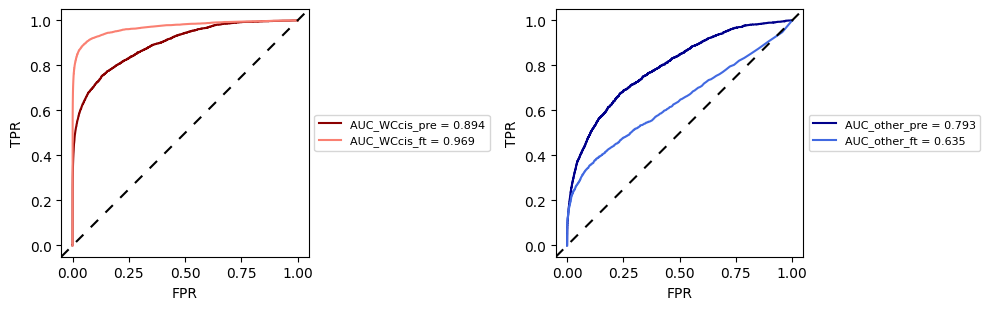

In [17]:
# Plot
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1, box_aspect=1)
plt.plot(fpr3, tpr3, label = "AUC_WCcis_pre = %1.3f" % (auc(fpr3, tpr3)), c="darkred")
plt.plot(fpr4, tpr4, label = "AUC_WCcis_ft = %1.3f" % (auc(fpr4, tpr4)), c="salmon")
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

plt.subplot(1, 2, 2, box_aspect=1)
plt.plot(fpr5, tpr5, label = "AUC_other_pre = %1.3f" % (auc(fpr5, tpr5)), c="darkblue")
plt.plot(fpr6, tpr6, label = "AUC_other_ft = %1.3f" % (auc(fpr6, tpr6)), c="royalblue")
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
plt.tight_layout()
plt.show()

Permutation test

In [ ]:
n_permut = 10000
permutdf = pd.DataFrame(index=np.arange(n_permut), columns=["AUCpre", "AUCft"])
otherpooled = pd.DataFrame({"true": othervalues[~(WCcisvalues==1)], "pre": pretrained[~(WCcisvalues==1)], "ft": finetuned[~(WCcisvalues==1)]})
truediff = roc_auc_score(otherpooled.true, otherpooled.pre) - roc_auc_score(otherpooled.true, otherpooled.ft)
for i in range(n_permut):
    resample = otherpooled.sample(n=otherpooled.shape[0], replace=True)
    permutdf.loc[i] = [roc_auc_score(resample.true, resample.pre), roc_auc_score(resample.true, resample.ft)]
permutdf["diffAUC"] = permutdf["AUCpre"] - permutdf["AUCft"]

In [ ]:
(np.sum(permutdf["diffAUC"].values < 0)+1)/(permutdf.shape[0] +1)

#### Check differences between pretrained and finetuned

In [17]:
diff_pre_vs_ft = pd.DataFrame({"pretrained":pretrained,
                               "finetuned":finetuned,
                               "contactType": ["WCcis" if s==1.0 and s==WCcisvalues[n] else "other" if s==1.0 and s==othervalues[n] else "nocontact" for n,s in enumerate(truevalues)]})

In [18]:
diff_pre_vs_ft

,pretrained,finetuned,contactType
0,7.713598,2.741814e-06,nocontact
1,2.611323,4.172325e-07,nocontact
2,4.571239,2.384186e-06,nocontact
3,3.060171,1.788139e-07,nocontact
4,4.054915,1.013279e-06,nocontact
...,...,...,...
1240543,0.512017,1.788139e-07,nocontact
1240544,1.093838,2.980232e-07,nocontact
1240545,1.090070,2.384186e-07,nocontact
1240546,3.937610,7.748604e-07,nocontact


In [19]:
no_supervised_pred_df = diff_pre_vs_ft[diff_pre_vs_ft['finetuned']<0.5].sort_values('pretrained', ascending=False).copy()
no_supervised_pred_df

,pretrained,finetuned,contactType
10905,17.979799,1.168251e-04,WCcis
1060422,17.755978,9.536743e-07,WCcis
10959,17.274855,3.850460e-05,WCcis
1060371,16.045111,4.172325e-07,WCcis
1057298,16.014351,5.279541e-03,WCcis
...,...,...,...
699133,0.008452,2.682209e-06,nocontact
704643,0.008451,8.344650e-07,nocontact
819445,0.007044,8.761883e-06,nocontact
812175,0.007044,1.370907e-05,nocontact


In [20]:
no_supervised_pred_df.contactType.unique()

array(['WCcis', 'nocontact', 'other'], dtype=object)

In [21]:
no_supervised_pred_all_df = no_supervised_pred_df.copy()
no_supervised_pred_all_df

,pretrained,finetuned,contactType
10905,17.979799,1.168251e-04,WCcis
1060422,17.755978,9.536743e-07,WCcis
10959,17.274855,3.850460e-05,WCcis
1060371,16.045111,4.172325e-07,WCcis
1057298,16.014351,5.279541e-03,WCcis
...,...,...,...
699133,0.008452,2.682209e-06,nocontact
704643,0.008451,8.344650e-07,nocontact
819445,0.007044,8.761883e-06,nocontact
812175,0.007044,1.370907e-05,nocontact


In [22]:
no_supervised_pred_all_df['contacts'] = no_supervised_pred_all_df['contactType'].isin(['other', 'WCcis']).astype(int)


In [23]:
no_supervised_pred_all_df

,pretrained,finetuned,contactType,contacts
10905,17.979799,1.168251e-04,WCcis,1
1060422,17.755978,9.536743e-07,WCcis,1
10959,17.274855,3.850460e-05,WCcis,1
1060371,16.045111,4.172325e-07,WCcis,1
1057298,16.014351,5.279541e-03,WCcis,1
...,...,...,...,...
699133,0.008452,2.682209e-06,nocontact,0
704643,0.008451,8.344650e-07,nocontact,0
819445,0.007044,8.761883e-06,nocontact,0
812175,0.007044,1.370907e-05,nocontact,0


In [24]:
no_supervised_pred_all_df.iloc[:10]

,pretrained,finetuned,contactType,contacts
10905,17.979799,1.168251e-04,WCcis,1
1060422,17.755978,9.536743e-07,WCcis,1
10959,17.274855,3.850460e-05,WCcis,1
1060371,16.045111,4.172325e-07,WCcis,1
1057298,16.014351,5.279541e-03,WCcis,1
86018,15.953200,1.788139e-07,nocontact,0
1066813,15.587021,1.013279e-06,other,1
535834,15.487743,4.055176e-01,WCcis,1
536221,15.348127,3.775024e-02,WCcis,1
535962,15.161956,2.722168e-01,WCcis,1


In [25]:
no_supervised_pred_all_df['precision'] = no_supervised_pred_all_df['contacts'].cumsum()/np.arange(1,len(no_supervised_pred_all_df)+1)

In [26]:
no_supervised_pred_all_df

,pretrained,finetuned,contactType,contacts,precision
10905,17.979799,1.168251e-04,WCcis,1,1.000000
1060422,17.755978,9.536743e-07,WCcis,1,1.000000
10959,17.274855,3.850460e-05,WCcis,1,1.000000
1060371,16.045111,4.172325e-07,WCcis,1,1.000000
1057298,16.014351,5.279541e-03,WCcis,1,1.000000
...,...,...,...,...,...
699133,0.008452,2.682209e-06,nocontact,0,0.002689
704643,0.008451,8.344650e-07,nocontact,0,0.002689
819445,0.007044,8.761883e-06,nocontact,0,0.002689
812175,0.007044,1.370907e-05,nocontact,0,0.002689


In [27]:
no_supervised_pred_all_df[no_supervised_pred_all_df['precision']==.5]

,pretrained,finetuned,contactType,contacts,precision
453201,13.527816,0.000003,nocontact,0,0.5
379212,13.474041,0.000004,WCcis,1,0.5


In [28]:
no_supervised_pred_all_df['contacts'].sum()

3328

In [29]:
len(no_supervised_pred_all_df[no_supervised_pred_all_df.pretrained>13.5])

59

In [33]:
from plotnine import *
cowplot_theme = theme(
    # Set the background to white and remove panel border
    panel_background=element_blank(),
    panel_border=element_blank(),

    # Light grey grid lines
    panel_grid_major=element_line(color='lightgrey', size=0.5),
    panel_grid_minor=element_blank(),

    # Minimize axis ticks
    axis_ticks=element_blank(),
    axis_text_x=element_text(size=12),
    axis_text_y=element_text(size=12),

    # Simple font
    text=element_text(color='black'),
    figure_size = (2.5,2.5),
    axis_title_x=element_text(size=12),
    axis_title_y=element_text(size=12)
)

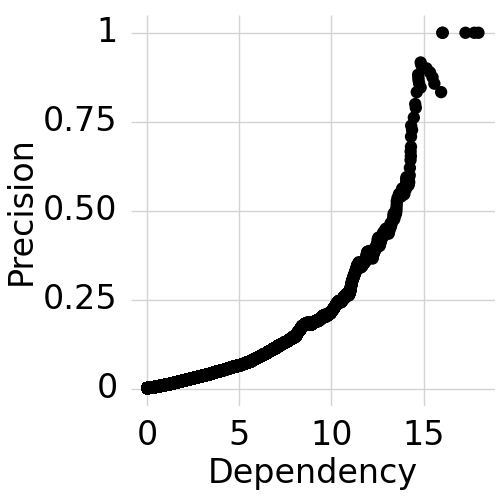

<Figure Size: (250 x 250)>

In [34]:
p = (ggplot(no_supervised_pred_all_df, aes('pretrained', 'precision'))
    + geom_point()
    + cowplot_theme
    + labs(x='Dependency', y='Precision'))
p

In [35]:
ggsave(p, 'fig4_missed_supervised_contacts.png', dpi=500)

/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 2.5 x 2.5 in image.
/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /s/project/multispecies/fungi_code/ci_matrices/dna-lm-interactions-paper/figures/fig4_missed_supervised_contacts.png
